In [1]:
!pip install inference inference-gpu supervision opencv-python

  Using cached inference-0.23.0-py3-none-any.whl.metadata (14 kB)
  Using cached inference_gpu-0.23.0-py3-none-any.whl.metadata (14 kB)
  Using cached supervision-0.24.0-py3-none-any.whl.metadata (14 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached aiortc-1.9.0-cp38-abi3-win_amd64.whl.metadata (5.6 kB)
  Using cached APScheduler-3.10.1-py3-none-any.whl.metadata (5.7 kB)
  Using cached Cython-3.0.0-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached fastapi-0.110.3-py3-none-any.whl.metadata (24 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached piexif-1.1.3-py2.py3-none-any.whl.metadata (3.7 kB)
  Using cached pillow-10.4.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
  Using cached prometheus_fastapi_instrumentator-6.0.0-py3-none-any.whl.metadata (13 kB)
  Using cached redis-5.1.1-py3-none-any.whl.metadata (9.1 kB)
  Using c


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install torch

   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/203.1 MB 3.1 MB/s eta 0:01:07
   ---------------------------------------- 0.2/203.1 MB 2.9 MB/s eta 0:01:11
   ---------------------------------------- 0.3/203.1 MB 2.5 MB/s eta 0:01:23
   ---------------------------------------- 0.4/203.1 MB 2.7 MB/s eta 0:01:16
   ---------------------------------------- 0.5/203.1 MB 2.7 MB/s eta 0:01:16
   ---------------------------------------- 0.6/203.1 MB 2.9 MB/s eta 0:01:11
   ---------------------------------------- 0.8/203.1 MB 2.8 MB/s eta 0:01:13
   ---------------------------------------- 0.9/203.1 MB 2.8 MB/s eta 0:01:13
   ---------------------------------------- 1.0/203.1 MB 2.8 MB/s eta 0:01:13
   ---------------------------------------- 1.1/203.1 MB 2.8 MB/s eta 0:01:12
   ---------------------------------------- 1.2/203.1 MB 3.0 MB/s eta 0:01:09



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. Training on GPU!")
else:
    print("CUDA is not available. Training on CPU.")

CUDA is not available. Training on CPU.


[10/23/24 19:12:37] WARNING  Your inference package version 0.23.0 is out of date! Please upgrade to ]8;id=746691;file://c:\Users\isss1\GitHub\soccer-computer-vision-analysis\soccer-env\Lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=265842;file://c:\Users\isss1\GitHub\soccer-computer-vision-analysis\soccer-env\Lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.24.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[1195.,  367., 1238.,  459.],
       [  60.,  526.,  122.,  647.],
       [1656.,  580., 1726.,  701.],
       [1503.,  426., 1555.,  527.],
       [1095.,  461., 1138.,  566.],
       [ 857.,  439.,  914.,  535.],
       [ 756.,  382.,  803.,  481.],
       [ 850.,  344.,  891.,  427.],
       [ 800.,  317.,  843.,  387.],
       [1150.,  349., 1178.,  426.],
       [ 370.,  404.,  409.,  510.],
       [1321.,  412., 1350.,  505.],
       [1183.,  313., 1214.,  384.],
       [1459.,  389., 1501.,  483.],
       [1315.,  347., 1339.,  416.],
       [1045.,  419., 1081.,  478.],
       [1642.,  428., 1672.,  534.],
       [1051.,  365., 1072.,  433.],
       [ 747.,  420.,  770.,  442.]]), mask=None, confidence=array([0.93859369, 0.9361639 , 0.93506873, 0.92912686, 0.92835104,
       0.92403758, 0.92248756, 0.9132008 , 0.90408027, 0.89720261,
       0.89320207, 0.89172792, 0.88695693, 0.8834542 , 0.86871785,
       0.8426497 , 0.84187245, 0.79695284, 0.60329545]),

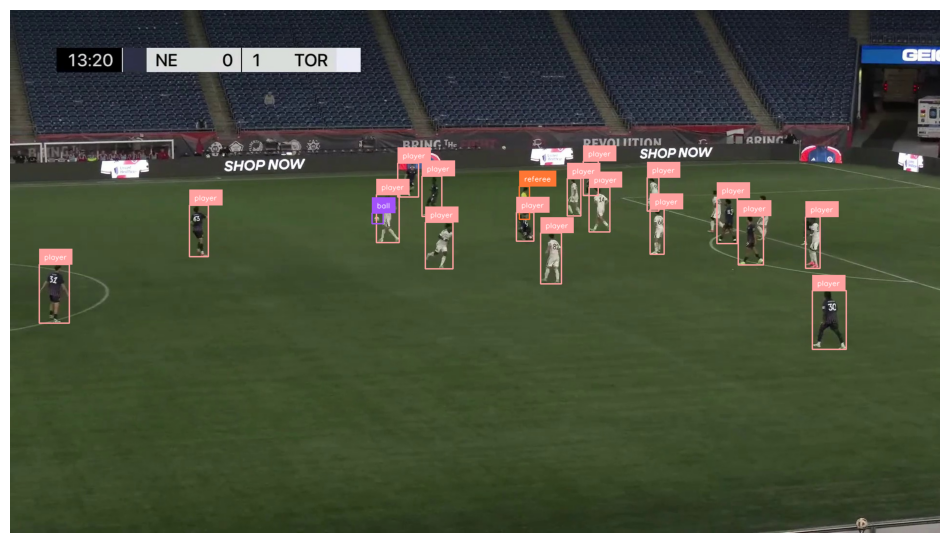

In [2]:
from inference import get_model
import supervision as sv
import cv2

# define the image url to use for inference
image_file = "images-object/frame600.jpg"
image = cv2.imread(image_file)

# load a pre-trained yolov8n model
objectModel = get_model(model_id="soccer-computer-vision-acffy/3")

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.

results = objectModel.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
print(detections)

annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

In [15]:
import supervision as sv
import os

sourceVideoPath = "C:\\Users\\isss1\\OneDrive\\Documents\\Wondershare\\Wondershare Filmora\\Output\\clip_14.mp4"

boxAnnotator = sv.BoxAnnotator()
labelAnnotator = sv.LabelAnnotator()

def getAnnotatedFrame(frame, index):
    result = objectModel.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    labels = [f"{className} {confidence:.2f}" for className, confidence in zip(detections['class_name'], detections.confidence)]

    annotatedFrame = frame.copy()
    annotatedFrame = boxAnnotator.annotate(scene=annotatedFrame, detections=detections)
    annotatedFrame = labelAnnotator.annotate(scene=annotatedFrame, detections=detections, labels=labels)

    return annotatedFrame

outputFolder = "annotated-footage"

if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

print("Creating sample footage, please wait...")
sv.process_video(source_path=sourceVideoPath, target_path=f'{outputFolder}/annotated.mp4', callback=getAnnotatedFrame)
print(f"Finished creating sample footage. Check the {outputFolder} folder.")

Creating sample footage, please wait...


KeyboardInterrupt: 

Keypoints below
[[0.08356652 0.00074077 0.01272151 0.05015865 0.1145637  0.109267
  0.04352885 0.05495062 0.1142152  0.10284013 0.13076904 0.11148074
  0.10859358 0.06996366 0.3405916  0.30385023 0.33011284 0.3365577
  0.35931435 0.374197   0.32776266 0.45378926 0.1671009  0.00315541
  0.04691771 0.12943709 0.29442897 0.21791983 0.2541824  0.00102589
  0.27193314 0.38471743 0.13947976 0.13319343 0.22583771 0.21966308]]


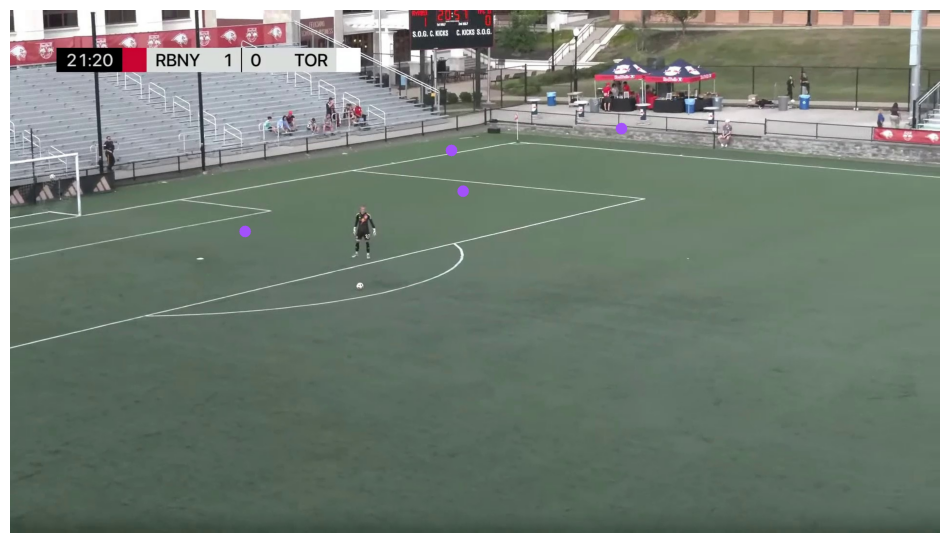

In [10]:
import supervision as sv
from inference import get_model
import numpy as np

# Keypoint Detection
demoModel = "football-field-detection-f07vi/14"
mostRecentModel = "soccer-field-detection-sbywb/5"

keypointModel = get_model(model_id=mostRecentModel)

print(keypointModel)

image_file = "images-pitch/frame12.jpg"
image = cv2.imread(image_file)

result = keypointModel.infer(image, confidence=0.60)[0]
keypoints = sv.KeyPoints.from_inference(result)

print("Keypoints below")
print(keypoints.confidence)

filter = keypoints.confidence > 0.35
keypoints.xy = keypoints.xy[filter][np.newaxis]

vertex_annotator = sv.VertexAnnotator(radius=12)
annotated_image = vertex_annotator.annotate(image.copy(), keypoints)

sv.plot_image(annotated_image)